In [4]:
import pandas as pd
import seaborn as sns 
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Load variables from .env file
load_dotenv()

# Connection details
server = os.getenv("DB_SERVER")        # Change to your server name, db name and other credintials
database = os.getenv("DB_DATABASE")
driver = os.getenv("DB_DRIVER")
trusted = os.getenv("DB_TRUSTED_CONNECTION")

connection_string = (
    f"mssql+pyodbc://@{server}/{database}"
    f"?driver={driver.replace(' ', '+')}"
    f"&trusted_connection={trusted}"
)

# Create engine with Windows Authentication
engine = create_engine(connection_string)

query1 = "SELECT * FROM dbo.price_elasticity_inputs;"
query2 = "SELECT * FROM dbo.pricing_simulation_base;"

df1 = pd.read_sql(query1, engine)
df2 = pd.read_sql(query2, engine)

In [5]:
# Quick dataset check
df1.head()
df1.describe()
df1.dtypes

Product ID              object
Category                object
Sub-Category            object
order_year_month        object
total_quantity         float64
total_sales            float64
total_profit           float64
total_profit_margin    float64
price_per_unit         float64
avg_discount           float64
dtype: object

In [6]:
# Standardize column names and turn to Python-friendly format for regression formulas
df1.columns = df1.columns.str.replace(" ", "_")
df1["Sub-Category"] = df1.rename(columns={"Sub-Category": "Sub_Category"}, inplace=True)
df1.isnull().sum()

Product_ID                0
Category                  0
Sub_Category              0
order_year_month          0
total_quantity            0
total_sales               0
total_profit              0
total_profit_margin       0
price_per_unit            0
avg_discount              0
Sub-Category           9294
dtype: int64

In [7]:
# Create a working copy to avoid mutating the original dataset
df_model = df1.copy()

# Log-transform quantity and price so coefficients can be interpreted as elasticity
df_model['log_quantity'] = np.log(df_model['total_quantity'])
df_model['log_price'] = np.log(df_model['price_per_unit'])

# Baseline log-log model:
# This captures the overall relationship between price and quantity,
# but ignores product heterogeneity, seasonality, and structural differences.
model_1 = smf.ols(
    formula="log_quantity ~ log_price",
    data=df_model
).fit()

print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:           log_quantity   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.2287
Date:                Sun, 01 Feb 2026   Prob (F-statistic):              0.632
Time:                        19:10:22   Log-Likelihood:                -8623.6
No. Observations:                9294   AIC:                         1.725e+04
Df Residuals:                    9292   BIC:                         1.727e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.2295      0.014     89.730      0.0

count    1862.000000
mean        2.381847
std         1.063666
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: unique_price_count, dtype: float64


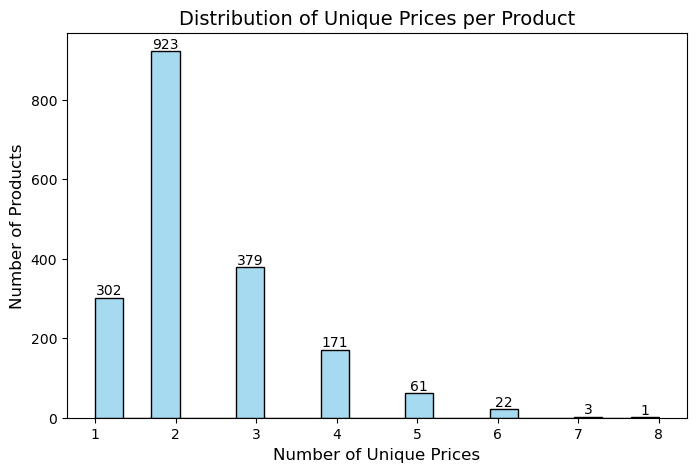

In [8]:
# Count how many distinct prices each product is sold at.
# This helps assess whether product-level elasticity is even identifiable.
price_counts = df1.groupby("Product_ID")["price_per_unit"].nunique().reset_index()
price_counts.rename(columns={"price_per_unit": "unique_price_count"}, inplace=True)

# Summarize price variation distribution
print(price_counts['unique_price_count'].describe())

# Visualize how many products have 1 or multiple unique prices
plt.figure(figsize=(8,5))
ax = sns.histplot(
    price_counts['unique_price_count'],
    bins=20,
    kde=False, 
    color='skyblue',
    edgecolor='black'
)

plt.title("Distribution of Unique Prices per Product", fontsize=14)
plt.xlabel("Number of Unique Prices", fontsize=12)
plt.ylabel("Number of Products", fontsize=12)

# Annotate counts on each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', 
                    xy=(p.get_x() + p.get_width()/2, height), 
                    ha='center', va='bottom', fontsize=10)

plt.show()

In [9]:
#Most products have only two unique prices, meaning product-level elasticity estimates are unreliable.
#This justifies moving to a more aggregated modeling strategy. We will use sub-category level aggregation × month

In [10]:
# Economic motivation:
# ln(Q) = β0 + β1 ln(P_effective) + controls + ε
# Focus on price variation where it actually exists.

# Aggregate to sub-category × month
# Sums quantities and averages prices/discounts to reduce noise and get meaningful units for analysis.
df_sc = df1.groupby(["Sub_Category", "order_year_month"]).agg(
    total_quantity=("total_quantity", "sum"),
    avg_price=("price_per_unit", "mean"),
    avg_discount=("avg_discount", "mean")
).reset_index()

# Effective price: 
# Average price already takes into account the discounts, so no adjustment is needed
df_sc["effective_price"] = df_sc["avg_price"]

# Log-transform for elasticity
df_sc["log_quantity"] = np.log(df_sc["total_quantity"])
df_sc["log_price"] = np.log(df_sc["effective_price"])

# Time extract (month/year)
df_sc["month"] = pd.to_datetime(df_sc["order_year_month"]).dt.month
df_sc["year"] = pd.to_datetime(df_sc["order_year_month"]).dt.year

# Demean by sub-category (fixed effects)
# Removes differences across subcategories so the regression focuses on within-subcategory price effects.
df_sc["log_quantity_dm"] = (df_sc["log_quantity"] - df_sc.groupby("Sub_Category")["log_quantity"].transform("mean"))
df_sc["log_price_dm"] = (df_sc["log_price"] - df_sc.groupby("Sub_Category")["log_price"].transform("mean"))

# Regression
# log_price_dm is the main coefficient: within-subcategory price elasticity
# C(month) and C(year) control for seasonality and yearly trends
model = smf.ols(
    "log_quantity_dm ~ log_price_dm + C(month) + C(year)",
    data=df_sc
).fit(cov_type="HC3")

print(model.summary())

# NOTE:
# We demeaned by sub-category to focus on within-category price effects (some categories always sell more, or have higher prices).
# Month/year controls account for seasonality and yearly trends.
# HC3 robust errors adjust for heteroscedasticity in sales data.
# This setup balances simplicity with capturing meaningful variation for price elasticity.

                            OLS Regression Results                            
Dep. Variable:        log_quantity_dm   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     56.17
Date:                Sun, 01 Feb 2026   Prob (F-statistic):          2.12e-112
Time:                        19:10:23   Log-Likelihood:                -541.42
No. Observations:                 782   AIC:                             1115.
Df Residuals:                     766   BIC:                             1189.
Df Model:                          15                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8558      0.076    -

In [11]:
# At the sub-category × month aggregation level, we are averaging across many products, each with different pricing and demand patterns. 
# For example, high-demand months may coincidentally have higher average prices due to promotions, new product launches, or seasonal effects. 
# This coefficient therefore captures the *within-sub-category relationship between average price and total quantity*, which can be weakly positive or negative. 
# The key is that we focus on *relative deviations* (demeaned values) to isolate meaningful price variation, rather than trying to estimate product-level demand slopes directly.

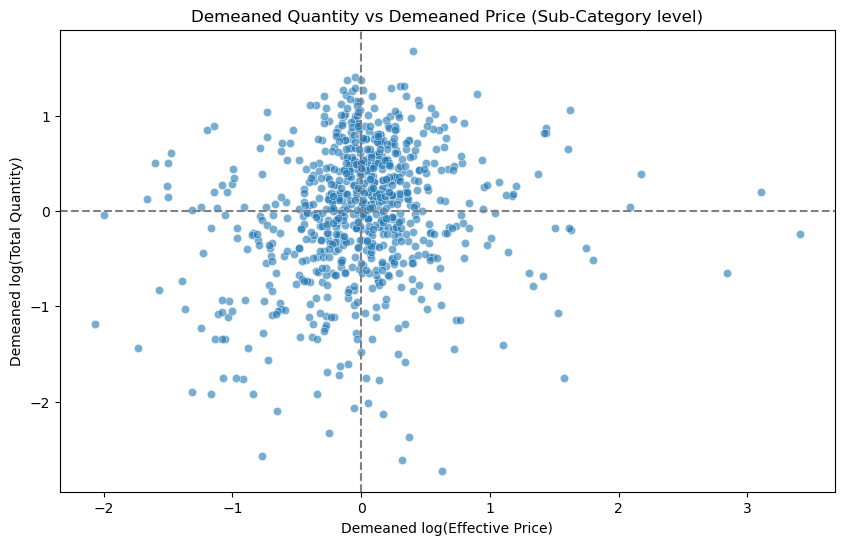

In [12]:
# Scatter for all sub-categories
plt.figure(figsize=(10,6))
sns.scatterplot(x="log_price_dm", y="log_quantity_dm", data=df_sc, alpha=0.6)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel("Demeaned log(Effective Price)")
plt.ylabel("Demeaned log(Total Quantity)")
plt.title("Demeaned Quantity vs Demeaned Price (Sub-Category level)")
plt.show()

In [13]:
elasticities = {}

# Function to run regression for each sub-category and store the log-price coefficient (aka. elasticity) in a dictionary
for sc in df_sc["Sub_Category"].unique():
    df_temp = df_sc[df_sc["Sub_Category"] == sc].copy()
    
    #demean within sub-category
    df_temp["log_quantity_dm"] = df_temp["log_quantity"] - df_temp["log_quantity"].mean()
    df_temp["log_price_dm"] = df_temp["log_price"] - df_temp["log_price"].mean()
    
    model = smf.ols("log_quantity_dm ~ log_price_dm + C(month) + C(year)", data=df_temp).fit(cov_type="HC3")
    
    # Save elasticity coefficient
    elasticities[sc] = model.params["log_price_dm"]
    
# Check dictionary
print(elasticities)

{'Accessories': -0.09131812322950313, 'Appliances': 0.5248992034869655, 'Art': -0.1942685796105425, 'Binders': 0.030568161069810335, 'Bookcases': 0.3202865934686391, 'Chairs': 0.5085587972654992, 'Copiers': 0.14101191739809493, 'Envelopes': 0.04848683710108442, 'Fasteners': 0.15060737799637136, 'Furnishings': 0.11496589008316435, 'Labels': 0.2128971710766791, 'Machines': 0.376652933252683, 'Paper': 0.10868104512670956, 'Phones': 0.18473743773132079, 'Storage': 0.10013068418109133, 'Supplies': 0.10562789874210021, 'Tables': -0.012173790681450192}


In [14]:
# df2 = pricing_simulation_base
df_base = df2.copy()

df_base["baseline_revenue"] = df_base["baseline_price"] * df_base["baseline_quantity"]
df_base["elasticity"] = df_base["Sub-Category"].map(elasticities)

# Quick check
df_base.head()

,Product ID,Category,Sub-Category,Region,baseline_quantity,baseline_price,baseline_profit,baseline_revenue,elasticity
0,FUR-BO-10000112,Furniture,Bookcases,Central,9.0,91.69,-117.88,825.210,0.320287
1,FUR-BO-10000330,Furniture,Bookcases,South,2.0,120.98,33.87,241.960,0.320287
2,FUR-BO-10000468,Furniture,Bookcases,South,2.5,44.69,9.72,111.725,0.320287
3,FUR-BO-10000468,Furniture,Bookcases,West,7.0,14.57,-183.63,101.990,0.320287
4,FUR-BO-10000780,Furniture,Bookcases,Central,3.0,136.67,-96.47,410.010,0.320287


In [15]:
# Example: simulate ±5% price changes
df_base["price_up5"] = df_base["baseline_price"] * 1.05
df_base["price_down5"] = df_base["baseline_price"] * 0.95

# Predicted quantity using price elasticity formula
# Qinew = Qibase × (Pibase / Pinew) ^ ϵsc
df_base["qty_up5"] = df_base["baseline_quantity"] * (df_base["price_up5"] / df_base["baseline_price"]) ** df_base["elasticity"]
df_base["qty_down5"] = df_base["baseline_quantity"] * (df_base["price_down5"] / df_base["baseline_price"]) ** df_base["elasticity"]

# Predicted revenue based on predicted price and quantity
df_base["rev_up5"] = df_base["price_up5"] * df_base["qty_up5"]
df_base["rev_down5"] = df_base["price_down5"] * df_base["qty_down5"]

In [16]:
# Function to get the best price:
# Returns the price that leads to highest revenue
def choose_best_price(row):
    options = {
        "baseline": row["baseline_revenue"],
        "up5": row["rev_up5"],
        "down5": row["rev_down5"]
    }
    best = max(options, key=options.get)
    if best == "baseline":
        return row["baseline_price"]
    elif best == "up5":
        return row["price_up5"]
    else:
        return row["price_down5"]

df_base["best_price"] = df_base.apply(choose_best_price, axis=1)

In [17]:
# Predicted best quantity and revenue based on predicted best price
df_base["pred_qty_best"] = df_base["baseline_quantity"] * (df_base["best_price"] / df_base["baseline_price"]) ** df_base["elasticity"]
df_base["pred_rev_best"] = df_base["best_price"] * df_base["pred_qty_best"]

In [18]:
df_base

,Product ID,Category,Sub-Category,Region,baseline_quantity,baseline_price,baseline_profit,baseline_revenue,elasticity,price_up5,price_down5,qty_up5,qty_down5,rev_up5,rev_down5,best_price,pred_qty_best,pred_rev_best
0,FUR-BO-10000112,Furniture,Bookcases,Central,9.0,91.69,-117.88,825.210,0.320287,96.2745,87.1055,9.141746,8.853351,880.117040,771.175559,96.2745,9.141746,880.117040
1,FUR-BO-10000330,Furniture,Bookcases,South,2.0,120.98,33.87,241.960,0.320287,127.0290,114.9310,2.031499,1.967411,258.059305,226.116550,127.0290,2.031499,258.059305
2,FUR-BO-10000468,Furniture,Bookcases,South,2.5,44.69,9.72,111.725,0.320287,46.9245,42.4555,2.539374,2.459264,119.158852,104.409289,46.9245,2.539374,119.158852
3,FUR-BO-10000468,Furniture,Bookcases,West,7.0,14.57,-183.63,101.990,0.320287,15.2985,13.8415,7.110247,6.885940,108.776114,95.311733,15.2985,7.110247,108.776114
4,FUR-BO-10000780,Furniture,Bookcases,Central,3.0,136.67,-96.47,410.010,0.320287,143.5035,129.8365,3.047249,2.951117,437.290857,383.162699,143.5035,3.047249,437.290857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,TEC-PH-10004912,Technology,Phones,Central,5.0,43.96,24.73,219.800,0.184737,46.1580,41.7620,5.045271,4.952845,232.879599,206.840705,46.1580,5.045271,232.879599
2640,TEC-PH-10004922,Technology,Phones,West,3.0,53.59,10.05,160.770,0.184737,56.2695,50.9105,3.027162,2.971707,170.336911,151.291083,56.2695,3.027162,170.336911
2641,TEC-PH-10004977,Technology,Phones,East,3.5,195.99,198.93,685.965,0.184737,205.7895,186.1905,3.531689,3.466991,726.784595,645.520856,205.7895,3.531689,726.784595
2642,TEC-PH-10004977,Technology,Phones,South,4.0,156.79,70.56,627.160,0.184737,164.6295,148.9505,4.036216,3.962276,664.480296,590.182969,164.6295,4.036216,664.480296


In [19]:
# Convert elasticity dictionary to DataFrame
df_elast = (
    pd.DataFrame.from_dict(elasticities, orient="index", columns=["elasticity"])
    .reset_index()
    .rename(columns={"index": "Sub-Category"})
)

df_elast

,Sub-Category,elasticity
0,Accessories,-0.091318
1,Appliances,0.524899
2,Art,-0.194269
3,Binders,0.030568
4,Bookcases,0.320287
5,Chairs,0.508559
6,Copiers,0.141012
7,Envelopes,0.048487
8,Fasteners,0.150607
9,Furnishings,0.114966


In [20]:
# Sub-categories where revenue increases when price decreases
df_elast_rev_down = df_elast[df_elast["elasticity"] < -1]

df_elast_rev_down

# Note: 
# None of the elasticities are below -1, meaning inelastic demands where higher price leads to higher revenue

,Sub-Category,elasticity


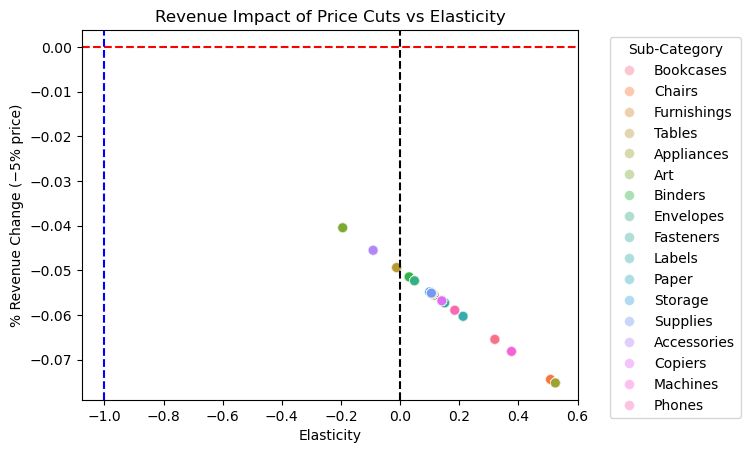

In [42]:
# Visualization of the elasticites for each sub-category
df_base["rev_change_down5_pct"] = ((df_base["rev_down5"] - df_base["baseline_revenue"]) / df_base["baseline_revenue"])

sns.scatterplot(
    data=df_base,
    x="elasticity",
    y="rev_change_down5_pct",
    alpha=0.4,
    hue="Sub-Category",
    s=50
)

plt.legend(
    title="Sub-Category",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.axhline(0, color="red", linestyle="--")
plt.axvline(-1, color="blue", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.xlabel("Elasticity")
plt.ylabel("% Revenue Change (−5% price)")
plt.title("Revenue Impact of Price Cuts vs Elasticity")
plt.show()

In [22]:
# Findings & Conclusion:
# - This analysis finds no strong evidence that price changes are a primary driver of demand within the available data.
# - Product-level elasticity estimates were unreliable due to limited price variation and high noise, while sub-category level 
# modeling, where sufficient variation exists, shows demand to be broadly inelastic (|ε| < 1) across all segments.
# - The positive and near-zero price coefficients suggest that observed differences in sales volumes are better explained by structural factors 
# such as sub-category characteristics and seasonality rather than price movements.
# - As a result, uniform price changes are unlikely to meaningfully influence demand, and pricing decisions should be evaluated alongside 
# non-price levers such as product mix, timing, and category strategy.